# Imports

In [ ]:
# numpy stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# general
import re
import math
import random
import unicodedata 
import string
from collections import Counter
from pprint import pprint
import sys

# nltk
import nltk
from nltk.util import ngrams
from nltk.corpus import gutenberg
from nltk.corpus import webtext

# others
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from scipy.special import softmax

# inline to include plots
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# (i) Biagram & Trigram language model

* In this senction we will implement a Biagram and a Trigram model, using the `gutenberg` corpus.

## Corpus Download

* In order to train the model we need to download a corpus from the ones included in NLTK.

In [ ]:
### Download if not imported
nltk.download('gutenberg')
nltk.download('punkt')

# nltk.download('brown')
# nltk.download('europarl_raw')
# nltk.download('reuters')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

* NLTK includes a small selection of texts from the Project Gutenberg electronic text archive, which contains some 25,000 free electronic books, hosted at http://www.gutenberg.org/. We begin by getting the Python interpreter to load the NLTK package, then ask to see nltk.corpus.gutenberg.fileids(), the file identifiers in this corpus:

In [ ]:
# load the package
gutenberg_corpus = nltk.corpus.gutenberg.fileids()
del gutenberg_corpus[3]

# print files
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
# print first sentence
gutenberg.raw(gutenberg_corpus[0]).split('.')[0]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her'

* Before proceeding we will combine the text from all files into one variable named `final_corpus`, lowering Capital letters in the process.
* Moreover we will count the total number of words.

In [ ]:
final_corpus = ''
for corpus in gutenberg_corpus:
    text = gutenberg.raw(fileids=corpus)    
    lower_text = text.lower()
    final_corpus += lower_text

In [ ]:
len(final_corpus.split())

1314109

## Cleaning the Text

In order to clean the text we will create two regexes as described below: 
1. We will only keep words (letters from a-z and sentence ending characters) removing punctuation and other characters.
2. We will remove multiple white spaces and linebreaks.

In [ ]:
def text_cleaning(text: str) -> str: 
    """ Function to only keep words and sentence ending characters, remove punctuation and other characters and remove multiple white spaces."""

    corpus = re.sub(r'[^a-zA-Z.?!\']', ' ', text)
    corpus = corpus.replace('[', '')
    corpus = corpus.replace(']', '.')
    corpus = re.sub(r'[[]/$@^&*()€:΄]', ' ', corpus)
    corpus = re.sub(' +', ' ', corpus)
    corpus = corpus.replace('\n', ' ')
    return corpus

In [ ]:
print(f'Before Cleaning: {final_corpus[:150]}', end='\n\n')
final_corpus = text_cleaning(final_corpus)

# Print the first sentence of the corpus
print(f'After Cleaning: {final_corpus[:150]}')

Before Cleaning: [emma by jane austen 1816]

volume i

chapter i


emma woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to

After Cleaning:  emma by jane austen volume i chapter i emma woodhouse handsome clever and rich with a comfortable home and happy disposition seemed to unite some of 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Possible nested set at position 1
  import sys


## Tokenize str input

* We now will transform the string input into a list, with each item containing one sentence of the corpus input, using the [`sent_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) function.

In [ ]:
def sentence_tokenization(text: str) -> list:
    """ Function that uses ntlk's sent_tokenize function. 'Tokenizers divide strings into lists of substrings.' """
    sentence_list = nltk.sent_tokenize(''.join(text))
    return sentence_list

In [ ]:
sentence_list = sentence_tokenization(final_corpus)

# Print the first two sentences of the corpus
print(sentence_list[1])

she was the youngest of the two daughters of a most affectionate indulgent father and had in consequence of her sister's marriage been mistress of his house from a very early period.


## Word tokenize

* For every sentence in the tokenized list, we will run the [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) function, which will split each list into words. We will iterate through all the sentences, as shown below:

In [ ]:
def word_tokenization(text: str) -> list:
    """ Function that applies word_tokenize if a given sentence."""
    words = nltk.word_tokenize(text)
    return words

# Run it for every entry in the sentence_list
corpus_in_list_of_words = [word_tokenization(f) for f in sentence_list]

# Print the first sentence of the corpus
print([i for i in corpus_in_list_of_words[1]])

['she', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', 'indulgent', 'father', 'and', 'had', 'in', 'consequence', 'of', 'her', 'sister', "'s", 'marriage', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.']


## Train-Test Split

* Having pre-processed the Corpus we will split the sentences into Three parts. One for training, one for validation and one for testing.

In [ ]:
# Set random seed for reproducibility 
random.seed(1)

# Shuffle and calculate split length
random.shuffle(corpus_in_list_of_words)
train_length = math.floor(0.6 * len(corpus_in_list_of_words))
dev_length   = test_length = math.floor(0.2 * len(corpus_in_list_of_words))

In [ ]:
train_corpus = [f for f in corpus_in_list_of_words[0 : train_length]]
dev_corpus   = [f for f in corpus_in_list_of_words[train_length : train_length + dev_length]]
test_corpus  = [f for f in corpus_in_list_of_words[train_length + dev_length:]]

## Create and count n-grams frequency (NLTK), Vocabulary, OOV Words

* In the next part of the code we will create and count n-grams frequencym for unigrams, biagrams and triagrams using [`nltk.util`](https://www.nltk.org/_modules/nltk/util.html).
* Moreover, using the unigram count, we will build the Vocabulary, which will consist words that appear at least 10 times in the *training* subset.
* All the out-of-vocabulary (OOV) words, will be replaced by a special token *UNK*.

In [ ]:
def calc_unigrams(corpus: list) -> Counter:
    """ Function that returns a Unigram Counter of a given corpus."""
    unigram_counter = Counter()
    for sentence in corpus:
        unigram_counter.update([gram for gram in ngrams(sentence, 1, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return unigram_counter

def calc_bigrams(corpus: list) -> Counter:
    """ Function that returns a Biagram Counter of a given corpus."""
    bigram_counter = Counter()
    for sentence in corpus:
        bigram_counter.update([gram for gram in ngrams(sentence, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return bigram_counter


def calc_trigrams(corpus: list) -> Counter:
    """ Function that returns a Trigram Counter of a given corpus."""
    trigram_counter = Counter()
    for sentence in corpus:
        trigram_counter.update([gram for gram in ngrams(sentence, 3, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return trigram_counter

In [ ]:
def replace_oov_words_train(corpus):
    """ Function that calculates and replaces OOV words.
    INPUT: Train corpus (list)
    OUTPUT: 
      OOV_word: dict with key containing OOC words and value the str 'UNK' -> dict
      clean_corpus: the original corpus having the OOV words replaced by 'UNK' -> list
      vocabulary: the words contained in the vocabulary -> set
    """

    unigram_counter = calc_unigrams(corpus)
    OOV_words = {k[0]:"UNK" for k, v in unigram_counter.items() if v < 10}
    clean_corpus = []
    for sentence in corpus:
        clean_corpus.append([OOV_words.get(n,n) for n in sentence])
    vocabulary = [f[0] for f in unigram_counter.keys() if f[0] not in OOV_words]
    vocabulary = set(vocabulary) # set for unique words
    return OOV_words, clean_corpus, vocabulary

In [ ]:
oov_words, clean_corpus, vocabulary = replace_oov_words_train(train_corpus)

In [ ]:
# print some random OOV words
random.sample(list(oov_words.keys()), 10)

['seafaring',
 'noxious',
 'agh',
 'millar',
 'halcyon',
 'marbles',
 'tricycle',
 'godlike',
 'reticulations',
 'groanes']

* Having found the OOV words and build the vocabulary, we can replace the OOV words in the remaining sets (dev, test)

In [ ]:
def replace_oov_words_dev_test(corpus, vocabulary, oov_words):
    clean_corpus = []
    for sentence in corpus:
        updated_sentence = ['UNK' if ((word not in vocabulary) or (word in oov_words)) else word for word in sentence]
        clean_corpus.append(updated_sentence)
    return clean_corpus

In [ ]:
dev_corpus = replace_oov_words_dev_test(dev_corpus, vocabulary, oov_words)
test_corpus = replace_oov_words_dev_test(test_corpus, vocabulary, oov_words)

* Finally we can calculate the various n-grams, in the training set, as well as the Vocabulary length.

In [ ]:
vocabulary_length = len(vocabulary)
unigram_counter = calc_unigrams(train_corpus)
bigram_counter = calc_bigrams(train_corpus)
trigram_counter = calc_trigrams(train_corpus)

In [ ]:
print(f'Vocabulary Length: {vocabulary_length}')
print('='*25, '\nUnigram 10 most common:')
pprint(unigram_counter.most_common(10))
print('='*25, '\nBigram 10 most common:')
pprint(bigram_counter.most_common(10))
print('='*25, '\nTrigram 10 most common:')
pprint(trigram_counter.most_common(10))

Vocabulary Length: 5932
Unigram 10 most common:
[(('the',), 41885),
 (('.',), 30625),
 (('and',), 26114),
 (('of',), 22028),
 (('to',), 20517),
 (('a',), 15413),
 (('i',), 12804),
 (('in',), 12476),
 (('that',), 9546),
 (('it',), 9529)]
Bigram 10 most common:
[(('.', '<e>'), 30392),
 (('!', '<e>'), 4846),
 (('of', 'the'), 4571),
 (('?', '<e>'), 4105),
 (('in', 'the'), 3138),
 (('<s>', 'i'), 3075),
 (('<s>', 'the'), 2366),
 (('to', 'the'), 1966),
 (('<s>', 'he'), 1726),
 (('to', 'be'), 1661)]
Trigram 10 most common:
[(('.', '<e>', '<e>'), 30392),
 (('!', '<e>', '<e>'), 4846),
 (('?', '<e>', '<e>'), 4105),
 (('<s>', '<s>', 'i'), 3075),
 (('<s>', '<s>', 'the'), 2366),
 (('<s>', '<s>', 'he'), 1726),
 (('<s>', '<s>', 'but'), 1644),
 (('<s>', '<s>', 'and'), 1280),
 (('<s>', '<s>', 'it'), 1255),
 (('<s>', '<s>', 'she'), 938)]


We observe here that the bigram (('the', 'lord'), 4269) is one of the 10 most common.

# (ii) Language cross-entropy and perplexity of Bigram and Trigram model


* Using Laplace smoothing and the dev set as a single sequece of sentences, we will calculate the n-gram probabilities, by summing the logs. Logs are used as they are more convinient, compared to the product, since the product of many probabilities might result in underfloat events.
* We  will add *start* (or *start1*, *start2*) at the beginning of each sentence, and *end* at the end of each sentence.
* Probabilities of the form P(*start*$\vert$…) or P(*start1*$\vert$…), P(*start2*$\vert$…) will be excluded in the computation of cross-entropy and perplexity.
* Finally, in order to achieve the best results possible we will tune the parameter $\alpha$ of a-smoothing.

In [ ]:
def calc_bi_prob(word1: str, word2: str, alpha: float, bigram_counter: Counter, unigram_counter: Counter, vocabulary_length: int) -> float:
    """ Function that calculates the Bigram model's probabilities using Laplace & a-smoothing."""
    #Bigram prob + laplace smoothing
    bigram_prob = (bigram_counter[(word1, word2)] + alpha) / (unigram_counter[(word1,)] + alpha * vocabulary_length)
    return bigram_prob

In [ ]:
def calc_tri_prob(word1: str, word2: str, word3:str, alpha: float, trigram_counter:Counter, bigram_counter:Counter, vocabulary_length: int) -> float:
    """ Function that calculates the Trigram model's probabilities using Laplace & a-smoothing."""
    #Bigram prob + laplace smoothing
    trigram_prob = (trigram_counter[(word1, word2, word3)] +alpha) / (bigram_counter[(word1, word2)] + alpha * vocabulary_length)
    return trigram_prob

* Bigram model perplexity/entropy in dev set.

In [ ]:
# initialize variables
perpl = []
HC_list = []
min, pos = 1, 0
min_range_bi = []
alpha_list = np.linspace(0.001,0.1,100)

for i, alpha in enumerate(alpha_list):

    sum_prob = 0
    bigram_cnt = 0
    for sent in dev_corpus:
        sent = ['<s>']  + sent + ['<e>']
        for idx in range(1,len(sent)):
            bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=alpha, bigram_counter=bigram_counter, unigram_counter=unigram_counter, vocabulary_length=vocabulary_length)
            sum_prob += math.log2(bigram_prob)
            bigram_cnt+=1

    HC_list.append(-sum_prob / bigram_cnt)
    perpl.append(math.pow(2,(-sum_prob / bigram_cnt)))

    if i == 0:
        min_entrp = -sum_prob / bigram_cnt
    elif (-sum_prob / bigram_cnt) <= min_entrp:
        min_range_bi.append(i)

perpl_bi = np.array(perpl)
entropy_bi = np.array(HC_list)
best_alpha_bi = alpha_list[np.argmin(perpl)]

print(f"The lowest perplexity/entropy regarding bigram model is : {round(np.min(perpl_bi),3)} / {round(np.min(entropy_bi),3)} at alpha= {np.round(best_alpha_bi, 3)}")

The lowest perplexity/entropy regarding bigram model is : 336.397 / 8.394 at alpha= 0.017


* Trigram model perplexity/entropy in dev set.

In [ ]:
# initialize variables
perpl = []
HC_list = []
min_range_tri = []
alpha_list = np.linspace(0.001,0.1,100)


for i, alpha in enumerate(alpha_list):

    sum_prob = 0
    trigram_cnt = 0
    for sent in dev_corpus:
        sent = ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']
        for idx in range(2,len(sent)):
            trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=alpha, trigram_counter=trigram_counter, bigram_counter=bigram_counter, vocabulary_length=vocabulary_length)
            sum_prob += math.log2(trigram_prob)
            trigram_cnt+=1

    # append Cross-entropy and perplexity
    HC_list.append(-sum_prob / trigram_cnt)
    perpl.append(math.pow(2,(-sum_prob / trigram_cnt)))

    if i == 0:
        min_entrp = -sum_prob / trigram_cnt
    elif (-sum_prob / trigram_cnt) <= min_entrp:
        min_range_tri.append(i)

perpl_tri = np.array(perpl)
entropy_tri = np.array(HC_list)
best_alpha_tri = alpha_list[np.argmin(perpl_tri)]

print(f"The lowest perplexity / entropy regarding trigram model is : {round(np.min(perpl_tri),3)} / {round(np.min(entropy_tri),3)} at alpha= {np.round(best_alpha_tri, 3)}")

The lowest perplexity / entropy regarding trigram model is : 694.189 / 9.439 at alpha= 0.004


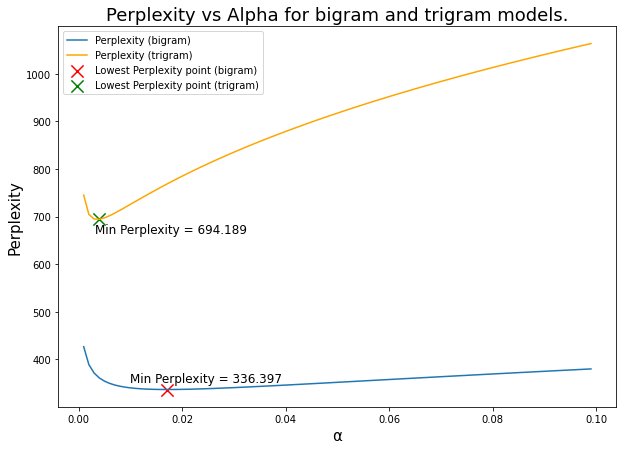

In [ ]:
# Find plot range
plot_range = max(int(min_range_tri[-1]),int(min_range_bi[-1]))

# define plot parameters for bigrama dn trigram
pos_bi = np.argmin(perpl_bi)
alpha_range_zoom_bi, perpl_zoom_bi = alpha_list[:plot_range], perpl_bi[:plot_range]
pos_tri = np.argmin(perpl_tri)
alpha_range_zoom_tri, perpl_zoom_tri = alpha_list[:plot_range], perpl_tri[:plot_range]


# Plot the results
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

# Bigram plot
ax.plot(alpha_range_zoom_bi, perpl_zoom_bi, label='Perplexity (bigram)', color='#1f77b4')   
ax.scatter(alpha_range_zoom_bi[pos_bi], perpl_zoom_bi[pos_bi], c='r', label='Lowest Perplexity point (bigram)', marker='x', s=150)
ax.annotate(f"Min Perplexity = {perpl_zoom_bi[pos_bi]:.3f}", xy=(alpha_range_zoom_bi[pos_bi]-0.007, perpl_zoom_bi[pos_bi]+15), fontsize=12)
ax.set_xlabel('α', fontsize=15)
ax.set_ylabel('Perplexity', fontsize=15)


# Trigram plot and twin axes
# ax2 = ax.twinx()
ax.plot(alpha_range_zoom_tri, perpl_zoom_tri, label='Perplexity (trigram)', color='orange')   
ax.scatter(alpha_range_zoom_tri[pos_tri], perpl_zoom_tri[pos_tri], c='g', label='Lowest Perplexity point (trigram)', marker='x', s=150)
ax.annotate(f"Min Perplexity = {perpl_zoom_tri[pos_tri]:.3f}", xy=(alpha_range_zoom_tri[pos_tri]-0.0009, perpl_zoom_tri[pos_tri]-30), fontsize=12)

# set title and legend
ax.set_title('Perplexity vs Alpha for bigram and trigram models.', fontsize=18)
_ = ax.legend(loc='upper left')


## Testing the language models

* Having found the optimal value of $\alpha$ for our models, we will proceed with evaluating the models, using previously unseen sentences.
* We will not include probabilities in the form of P(*start*$\vert$…) and P(*\start1*$\vert$…), P(*start2*$\vert$…) but will cound *end* tokens in the total length N of the test corpus.

In [ ]:
sum_prob = 0
log_prob_bigram_correct=[]
for sent in test_corpus:
    sent = ['<s>']  + sent + ['<e>']
    for idx in range(1,len(sent)):
        bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=best_alpha_bi, bigram_counter=bigram_counter, unigram_counter=unigram_counter, vocabulary_length=vocabulary_length)
        sum_prob += math.log2(bigram_prob)
        bigram_cnt+=1  
    log_prob_bigram_correct.append(sum_prob)
    sum_prob = 0

In [ ]:
pd.set_option('display.max_colwidth',1)
df_bigram = pd.DataFrame({"Correct Sentence":test_corpus, "Log Probability Correct":log_prob_bigram_correct})
df_bigram.head()

,Correct Sentence,Log Probability Correct
0,"[how, came, they, acquainted, ?]",-38.119949
1,"[for, himself, .]",-9.034187
2,"[talbot, for, ever, !]",-20.831215
3,"[UNK, UNK, why, do, you, shew, me, this, ?]",-82.643206
4,"[the, horse, kept, his, good, pace, and, by, noon, the, towers, of, the, castle, stood, out, against, the, sky, much, nearer, and, more, beautiful, .]",-203.721381


In [ ]:
sum_prob = 0
log_prob_trigram_correct=[]
for sent in test_corpus:
    # This was wrong in trigram we need 2 starts not 1
    sent = ['<s>'] + ['<s>']  + sent + ['<e>'] + ['<e>']
    for idx in range(2,len(sent)):
        trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=best_alpha_tri, trigram_counter=trigram_counter, bigram_counter=bigram_counter, vocabulary_length=vocabulary_length)
        sum_prob += math.log2(trigram_prob)  
    log_prob_trigram_correct.append(sum_prob)
    sum_prob = 0

In [ ]:
pd.set_option('display.max_colwidth',1)
df_trigram = pd.DataFrame({"Correct Sentence":test_corpus, "Log Probability Correct":log_prob_trigram_correct})
df_trigram.head()

,Correct Sentence,Log Probability Correct
0,"[how, came, they, acquainted, ?]",-45.045827
1,"[for, himself, .]",-15.487781
2,"[talbot, for, ever, !]",-13.115277
3,"[UNK, UNK, why, do, you, shew, me, this, ?]",-99.544735
4,"[the, horse, kept, his, good, pace, and, by, noon, the, towers, of, the, castle, stood, out, against, the, sky, much, nearer, and, more, beautiful, .]",-281.578390


### Bigram model

In [ ]:
for i in bigram_counter.items():
  if i[1]==0:
    print(i)

In [ ]:
test_sequence = []
for sent in test_corpus:
    test_sequence += ['<s>']  + sent + ['<e>']

sum_prob = 0
bigram_cnt = 0
for idx in range(1,len(test_sequence)):
    if test_sequence[idx] != '<s>':
        bigram_prob = calc_bi_prob(word1=test_sequence[idx-1], word2=test_sequence[idx], alpha=best_alpha_bi, bigram_counter=bigram_counter, unigram_counter=unigram_counter, vocabulary_length=vocabulary_length)
        sum_prob += math.log2(bigram_prob)
        bigram_cnt+=1
        
HC = -sum_prob / bigram_cnt
perpl = math.pow(2,HC)
#print(sum_prob)
#print(bigram_cnt)
print("Language Cross Entropy: {0:.3f}".format(HC))
print("Language Perplexity: {0:.3f}".format(perpl))

Language Cross Entropy: 8.415
Language Perplexity: 341.395


### Trigram model

In [ ]:
test_sequence = []
for sent in test_corpus:
    test_sequence += ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']

sum_prob = 0
trigram_cnt = 0
for idx in range(2,len(test_sequence)):
    if test_sequence[idx] != '<s>':
        trigram_prob = calc_tri_prob(word1=test_sequence[idx-2], word2=test_sequence[idx-1], word3=test_sequence[idx], alpha=best_alpha_tri, trigram_counter=trigram_counter, bigram_counter=bigram_counter, vocabulary_length=vocabulary_length)
        sum_prob += math.log2(trigram_prob)
        trigram_cnt+=1
        
HC = -sum_prob / trigram_cnt
perpl = math.pow(2,HC)
#print(sum_prob)
#print(trigram_cnt)
print("Language Cross Entropy: {0:.3f}".format(HC))
print("Language Perplexity: {0:.3f}".format(perpl))

Language Cross Entropy: 9.431
Language Perplexity: 690.201


# (iii) Spelling Corrector

* In this section we will develop a  context-aware spelling corrector for both spelling and grammatical errors using our bigram language model, a beam search decoder,
and the formulae of slide 19

we are updating the unigram counter for the start symbol < s > in order for the bigram probs to be calculated correctly.

In [ ]:
unigram_counter[('<s>',)] = len(train_corpus)
bigram_counter[('<s>','<s>')] = len(train_corpus)

## Beam search decoder

In [ ]:
# beam search decoder function
def beam_search(sent, l1, l2, k_init, topk_init, printing=True):
    predicted_sent = list()
    cumulative_ED_norm = [1] * k_init
    cumulative_bigram_prob_norm = [1] * k_init
    output_seq = [[] for x in range(k_init)]
    output_seq_temp = [[] for x in range(k_init)]
    choice = [['<s>'] for x in range(k_init)]
    
    # loop through each word in input sentence
    for idx in range(1,len(sent)):
        word_ED = list()
        word_ED_norm = list()
        bigram_prob = list()
        criteria = list()
        cumulative_ED_norm_temp = list()
        cumulative_bigram_prob_norm_temp = list()
      
        if idx==len(sent)-1:
            k=1
            topk=1
        elif idx==1:
            k=1
            topk=topk_init
        else:
            k=k_init
            topk=topk_init
      
        # loop k times to find top probabilities from k previous selections
        for i in range(k):
          
            # loop through each word in vocabulary
            for word in vocabulary:
                # edit distance for P(w|t)
                word_ED.append(1/(nltk.edit_distance(sent[idx], word)+1))
                # for the first iteration begin with the <s> symbol
                if idx==1:
                    bigram_prob.append(calc_bi_prob(word1=sent[0],
                                                    word2=word, 
                                                    alpha=best_alpha_bi, 
                                                    bigram_counter=bigram_counter, 
                                                    unigram_counter=unigram_counter, 
                                                    vocabulary_length=vocabulary_length))
                # else use the previously selected k choices
                else:
                    bigram_prob.append(calc_bi_prob(word1=choice[i][0], 
                                                    word2=word, 
                                                    alpha=best_alpha_bi, 
                                                    bigram_counter=bigram_counter, 
                                                    unigram_counter=unigram_counter, 
                                                    vocabulary_length=vocabulary_length))
            # normalize to sum to 1
            word_ED_norm = softmax(word_ED)
            bigram_prob_norm = softmax(bigram_prob)
            
            cumulative_ED_norm_temp = np.multiply(np.array(word_ED_norm),cumulative_ED_norm[i])
            cumulative_bigram_prob_norm_temp = np.multiply(np.array(bigram_prob_norm),cumulative_bigram_prob_norm[i])
            
            # zip the argmax criterion for each vocabulary word, the vocabulary word and the k iteration from which it originates 
            criteria += list(zip((l1 * np.log10(np.array(cumulative_bigram_prob_norm_temp)) + l2 * np.log10(np.array(cumulative_ED_norm_temp))),
                                (np.array(cumulative_bigram_prob_norm_temp)),
                                (np.array(cumulative_ED_norm_temp)),
                                vocabulary,
                                [i for x in vocabulary]))
        # sort to find the top k
        criteria_sorted = sorted(criteria,key=lambda k: k[0], reverse=True)[:topk]
      
        # save the k choices [word, from which k it originates, the previous word]
        choice = [[x[3],x[4],choice[x[4]][0],x[1],x[2]] for x in criteria_sorted]
      
        # append in output sequence
        if idx==1:
            for i in range(topk):
                output_seq[i].append(choice[i][0])
        else:
            for i in range(topk):
                output_seq_temp[i] = output_seq[choice[i][1]] + [choice[i][0]]
            for i in range(topk):
                output_seq[i] = output_seq_temp[i]
        
        # cumulative probs
        for i in range(topk):
            cumulative_ED_norm[i] = choice[i][4]
            cumulative_bigram_prob_norm[i] = choice[i][3]
        
        
        if printing:
          print('============================================================')        
          print(f'step = {idx}')
          print(f'w = {sent[idx]}')
          print(f'top {topk_init} selections: (l1*logbigramprob+l2*logEDprob , bigramprob, EDprob, selectedword, sequence)')
          print(criteria_sorted)
          print('choice: (selected word, previous sequence, previous word)')
          print(choice)
          print('output seq:')
          print(output_seq)
          print('\n')

    return output_seq


# find and print the longest sequence since the last choice is only one    
def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
      
    return maxList, maxLength


## $λ_1$ $λ_2$ hyperparameter tuning

In [ ]:
# initialize variables
k_init = 3
topk_init = 3
l1_list = np.linspace(0.01,1,50)
fuzz_ratio = [[] for x in range(2)]

actual_phrase = "in consequence of her sister's marriage, been mistress of his house from a very early period"
test_phrase = "in consequencaae of her sistero's marriange, been moistress of hois house from a vry early period"
phrase_tokenized = nltk.word_tokenize(test_phrase)
sent = ['<s>']  + phrase_tokenized

for i, l1 in enumerate(l1_list):
    output_seq = beam_search(sent=sent, l1=l1, l2=1-l1, k_init=k_init, topk_init=topk_init, printing=False)
    fuzz_ratio[0].append(fuzz.ratio(" ".join(FindMaxLength(output_seq)[0]), actual_phrase))

best_l1a = l1_list[np.argmax(fuzz_ratio[0])]

print(f"The best fuzz ratio is : {round(np.max(fuzz_ratio[0]),3)} at l1= {np.round(best_l1a, 3)}, l2= {1-np.round(best_l1a, 3)}")


actual_phrase = "Tomorrow will bring something new, so leave today as a memory"
test_phrase = "Tomorrrow well bring somethiing new, so leav today as a memoory."
phrase_tokenized = nltk.word_tokenize(test_phrase)
sent = ['<s>']  + phrase_tokenized

for i, l1 in enumerate(l1_list):
    output_seq = beam_search(sent=sent, l1=l1, l2=1-l1, k_init=k_init, topk_init=topk_init, printing=False)
    fuzz_ratio[1].append(fuzz.ratio(" ".join(FindMaxLength(output_seq)[0]), actual_phrase))

best_l1b = l1_list[np.argmax(fuzz_ratio[1])]

print(f"The best fuzz ratio is : {round(np.max(fuzz_ratio[1]),3)} at l1= {np.round(best_l1b, 3)}, l2= {1-np.round(best_l1b, 3)}")

The best fuzz ratio is : 98 at l1= 0.01, l2= 0.99
The best fuzz ratio is : 93 at l1= 0.01, l2= 0.99


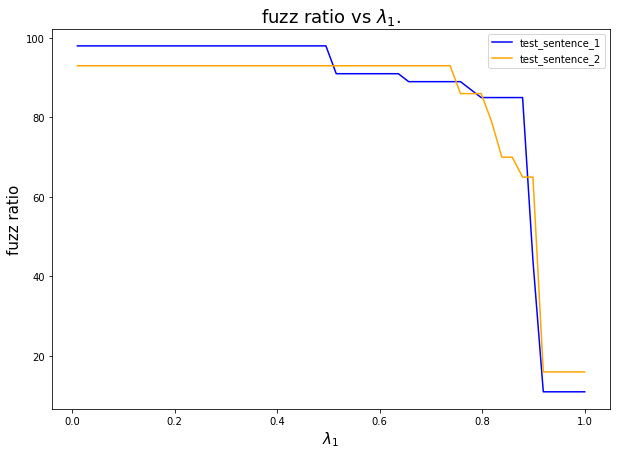

In [ ]:
# define plot parameters for bigram and trigram
pos_best_l1a = np.argmax(fuzz_ratio[0])
pos_best_l1b = np.argmax(fuzz_ratio[1])

# Plot the results
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

# plot
ax.plot(l1_list, fuzz_ratio[0], label='test_sentence_1', color='blue')   
#ax.scatter(l1_list[pos_best_l1a], fuzz_ratio[0][pos_best_l1a], c='r', label='best fuzz ratio point', marker='x', s=150)
ax.set_xlabel('$λ_1$', fontsize=15)
ax.set_ylabel('fuzz ratio', fontsize=15)

ax.plot(l1_list, fuzz_ratio[1], label='test_sentence_2', color='orange')   
#ax.scatter(l1_list[pos_best_l1b], fuzz_ratio[1][pos_best_l1b], c='r', label='best fuzz ratio point', marker='x', s=150)

# set title and legend
ax.set_title('fuzz ratio vs $λ_1$.', fontsize=18)
_ = ax.legend(loc='upper right')

We will choose $λ_1$=0.3 and $λ_2$=0.7 since the fuzz ratio remains maximum with this choice and also we have both factors influencing the result.

#### Test cases

In [ ]:
#input
#test_phrase = 'and the philistnine sayd to david cme to me'
#test_phrase = "and the philistnine sayid to david cme to me"
test_phrase = "in consequencaae of her sistero's marriange, been moistress of hois house from a vry early period"
#test_phrase = "as this sirence continued ivery dayy made it appear more stange and more UNK with the dissposition of both."
phrase_tokenized = nltk.word_tokenize(test_phrase)
sent = ['<s>']  + phrase_tokenized

#initialize params/vars
k_init = 3
topk_init = 3
l1 = 0.3
l2 = 0.7

output_seq = beam_search(sent=sent, l1=l1, l2=l2, k_init=k_init, topk_init=topk_init, printing=True)
#print(FindMaxLength(output_seq))

print('===== RESULTS ========================================')
print('test phrase:')
print(test_phrase)
print('     --------')
print('selected sequence:')
print(" ".join(FindMaxLength(output_seq)[0]))

step = 1
w = in
top 3 selections: (l1*logbigramprob+l2*logEDprob , bigramprob, EDprob, selectedword, sequence)
[(-3.5181720994824053, 0.00017057579865039082, 0.0003880899487875159, 'in', 0), (-3.66171637585779, 0.00018201760167653328, 0.00023538845266593415, 'i', 0), (-3.6676443704550836, 0.00017392155338484563, 0.00023538845266593415, 'it', 0)]
choice: (selected word, previous sequence, previous word)
[['in', 0, '<s>', 0.00017057579865039082, 0.0003880899487875159], ['i', 0, '<s>', 0.00018201760167653328, 0.00023538845266593415], ['it', 0, '<s>', 0.00017392155338484563, 0.00023538845266593415]]
output seq:
[['in'], ['i'], ['it']]


step = 2
w = consequencaae
top 3 selections: (l1*logbigramprob+l2*logEDprob , bigramprob, EDprob, selectedword, sequence)
[(-7.215214438782736, 2.878019057461972e-08, 8.401712230042743e-08, 'consequence', 0), (-7.240682955540091, 2.875045742545241e-08, 7.729948410573697e-08, 'consequences', 0), (-7.255883262406705, 2.875045742545241e-08, 7.352954378010221e-

## Testing the spelling corrector

In [ ]:
correct = ["He strives to keep the best lawn in the neighborhood.",
"He walked into the basement with the horror movie from the night before playing in his head.",
"She was the type of girl who wanted to live in a pink house.",
"As the rental car rolled to a stop on the dark road, her fear increased by the moment.",
"There are few things better in life than a slice of pie.",
"The stench from the feedlot permeated the car despite having the air conditioning on recycled air.",
"He told us a very exciting adventure story.",
"All you need to do is pick up the pen and begin.",
"Peanut butter and jelly caused the elderly lady to think about her past.",
"Green should have smelled more tranquil, but somehow it just tasted rotten.",
"She opened up her third bottle of wine of the night.",
"As the years pass by, we all know owners look more and more like their dogs.",
"There's no reason a hula hoop can't also be a circus ring.",
"Your girlfriend bought your favorite cookie crisp cereal but forgot to get milk.",
"Greetings from the galaxy MACS0647-JD, or what we call home.",
"The minute she landed she understood the reason this was a fly-over state.",
"I liked their first two albums but changed my mind after that charity gig.",
"The sunblock was handed to the girl before practice, but the burned skin was proof she did not apply it.",
"It took me too long to realize that the ceiling hadn't been painted to look like the sky.",
"He waited for the stop sign to turn to a go sign.",
"He never understood why what, when, and where left out who.",
"The stranger officiates the meal.",
"Instead of a bachelorette party",
"8% of 25 is the same as 25% of 8 and one of them is much easier to do in your head.",
"She wrote him a long letter, but he didn't read it.",
"Jeanne wished she has chosen the red button.",
"Their argument could be heard across the parking lot.",
"The near-death experience brought new ideas to light.",
"It was getting dark, and we weren’t there yet.",
"Yeah, I think it's a good environment for learning English."]

wrong = ["He strivess to keep then best lawn in the neighborhood.",
"He walked into the basement with the horrror movie from the night before play in his head.",
"She was thhe type of girl who want to live in a pink house.",
"As the rentall car rolled to a stop on the dark road, her fear increased by the moment.",
"There are few things better in life than a slice of pie.",
"The stench from the feedlot permeated the car despite having the air conditioning on recycled air.",
"He told us a verry exciting adventure story.",
"All you need to do is pick up the pen and begin.",
"Peanut butter and jelly caused the elderly lady to think about her past.",
"Green should have smelled more tranquil, but somehow it just tasted rotten.",
"She opened up her third bottle of wine of the night.",
"As the years pass by, we all knnow owners look more and more like their dogs.",
"There's no reason a hula hoop can't also be a circus ring.",
"Your girlfriend boughht your favorite cookie crisp cereal but forgot to get milk.",
"Greetings from the galaxy MACS0647-JD, or whhat we call home.",
"Then minutes she landed she understoods the reasson this was a fly-over state.",
"I liked their first two albums but changed my mind after that charity gig.",
"The sunblock was handed to the girl beffore practice, but the burned skin was proof she dad not apply it.",
"It took me too long to realize that the ceiling hadn't been painted to look like the sky.",
"He waiter for the sttop sign to turn to a go sign.",
"He never understood why what, when, annd whore left out who.",
"The strangler officciates the meal.",
"Instead of a bacheloreztte party",
"8% of 25 is tqhe same as 25% of 8 and one of them is much easier to do in your head.",
"She wrote him a long letter, but he didn't read it.",
"Jeanne washed she has cheosen the red button.",
"Their argument cloud be heard achross the parking lot.",
"The near-death experience brought new ideals to light.",
"It was getting dark, ankd we weren’t there yet.",
"Yeah, I think it's an good enviranment for learnting English."]


for actual_phrase, test_phrase in dict(zip(correct, wrong)).items():
  phrase_tokenized = nltk.word_tokenize(test_phrase)
  sent = ['<s>']  + phrase_tokenized
  output_seq = beam_search(sent=sent, l1=0.01, l2=1-0.01, k_init=3, topk_init=3, printing=False)
  print("Original Phrase:\t",actual_phrase)
  print("Error induced Phrase:\t",test_phrase)
  print("Corrected Phrase:\t"," ".join(FindMaxLength(output_seq)[0]))
  print('\n')
  

Original Phrase:	 He strives to keep the best lawn in the neighborhood.
Error induced Phrase:	 He strivess to keep then best lawn in the neighborhood.
Corrected Phrase:	 he strikes to keep then best lawn in the neighbourhood .


Original Phrase:	 He walked into the basement with the horror movie from the night before playing in his head.
Error induced Phrase:	 He walked into the basement with the horrror movie from the night before play in his head.
Corrected Phrase:	 he walked into the pavement with the horror move from the night before play in his head .


Original Phrase:	 She was the type of girl who wanted to live in a pink house.
Error induced Phrase:	 She was thhe type of girl who want to live in a pink house.
Corrected Phrase:	 the was the type of girl who want to live in a pink house .


Original Phrase:	 As the rental car rolled to a stop on the dark road, her fear increased by the moment.
Error induced Phrase:	 As the rentall car rolled to a stop on the dark road, her fear i